<a href="https://colab.research.google.com/github/Mino94/crack-project-AE/blob/main/crack_project_%EA%B9%80%EB%AF%BC%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crack Image Detection

- alibi detection - Auto Encoder 사용
- 정상 이미지만 넣어서 Crack들 outlier를 찾아 낼 것입니다.

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'mino94' # username
os.environ['KAGGLE_KEY'] = '' # key

In [2]:
!kaggle datasets download -d arunrk7/surface-crack-detection

surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q surface-crack-detection.zip

replace Negative/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Negative/00002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Negative/00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!pip install alibi_detect==0.5.0

     |████████████████████████████████| 163kB 8.5MB/s 
     |████████████████████████████████| 2.1MB 10.3MB/s 
     |████████████████████████████████| 901kB 36.5MB/s 
     |████████████████████████████████| 3.3MB 43.8MB/s 


In [6]:
# Import Packages

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Normal Images

In [8]:

img_list = glob('Negative/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2021)

def img_to_np(fpaths, resize=True):
  img_array = []
  for fname in fpaths:
    try:
      img = Image.open(fname).convert('RGB')
      if(resize): img = img.resize((64, 64))
      img_array.append(np.asarray(img))
    except:
      continue
  Images = np.array(img_array)
  return Images

x_train = img_to_np(train_img_list)
x_train = x_train.astype(np.float32) / 255.


x_val = img_to_np(val_img_list[:32])
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(18000, 64, 64, 3)
(32, 64, 64, 3)


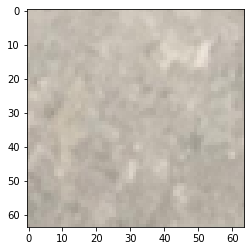

In [9]:
plt.imshow(x_train[0]);

# Modeling

In [10]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.005,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [11]:
od.fit(
    x_train,
    epochs=30,
    verbose=True
)

282/282 [=] - 18s 63ms/step - loss: -23362.6281


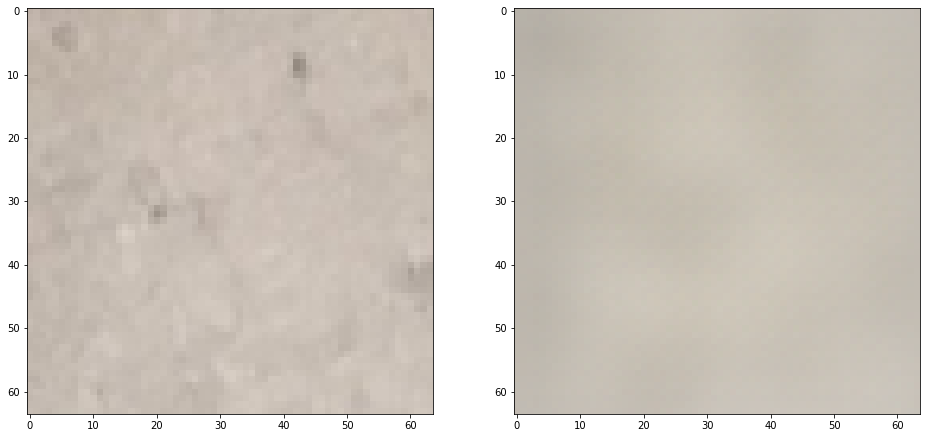

In [12]:
idx = 12
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

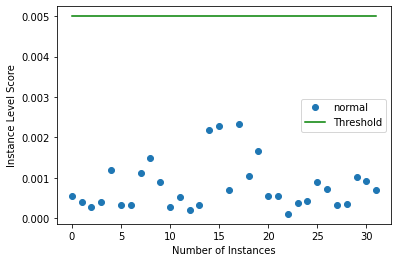

In [13]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

모두 정상이미지로만 학습을 합니다.

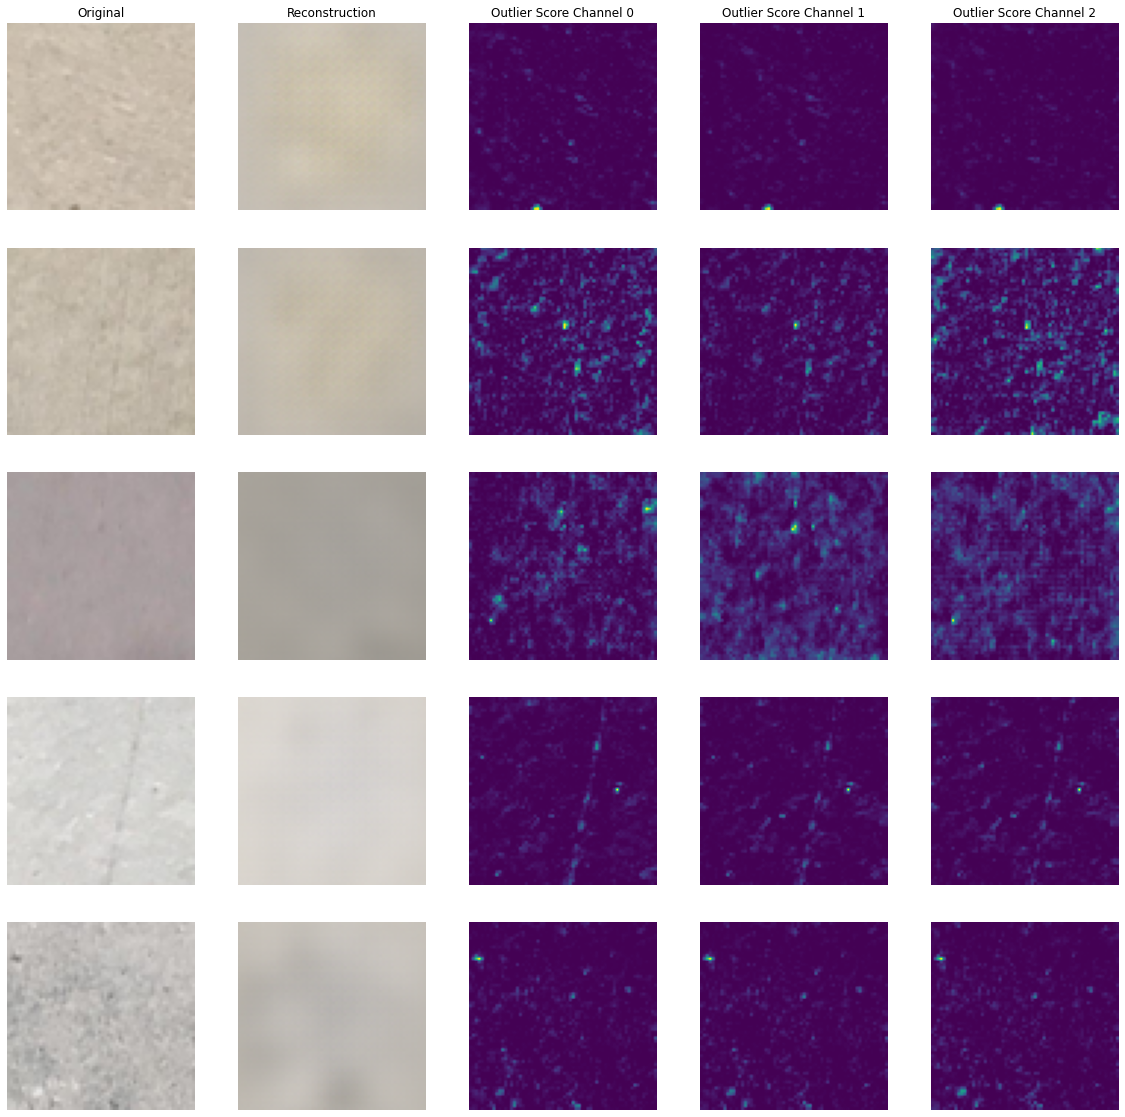

In [14]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

In [15]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

<Figure size 1440x1440 with 0 Axes>

In [16]:
test_img_list = glob('Positive/*.jpg')

x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 64, 64, 3)


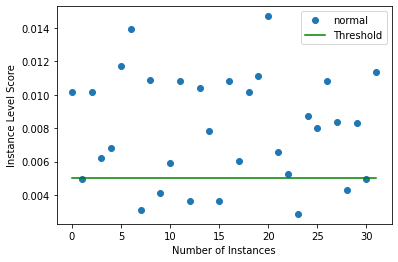

In [17]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

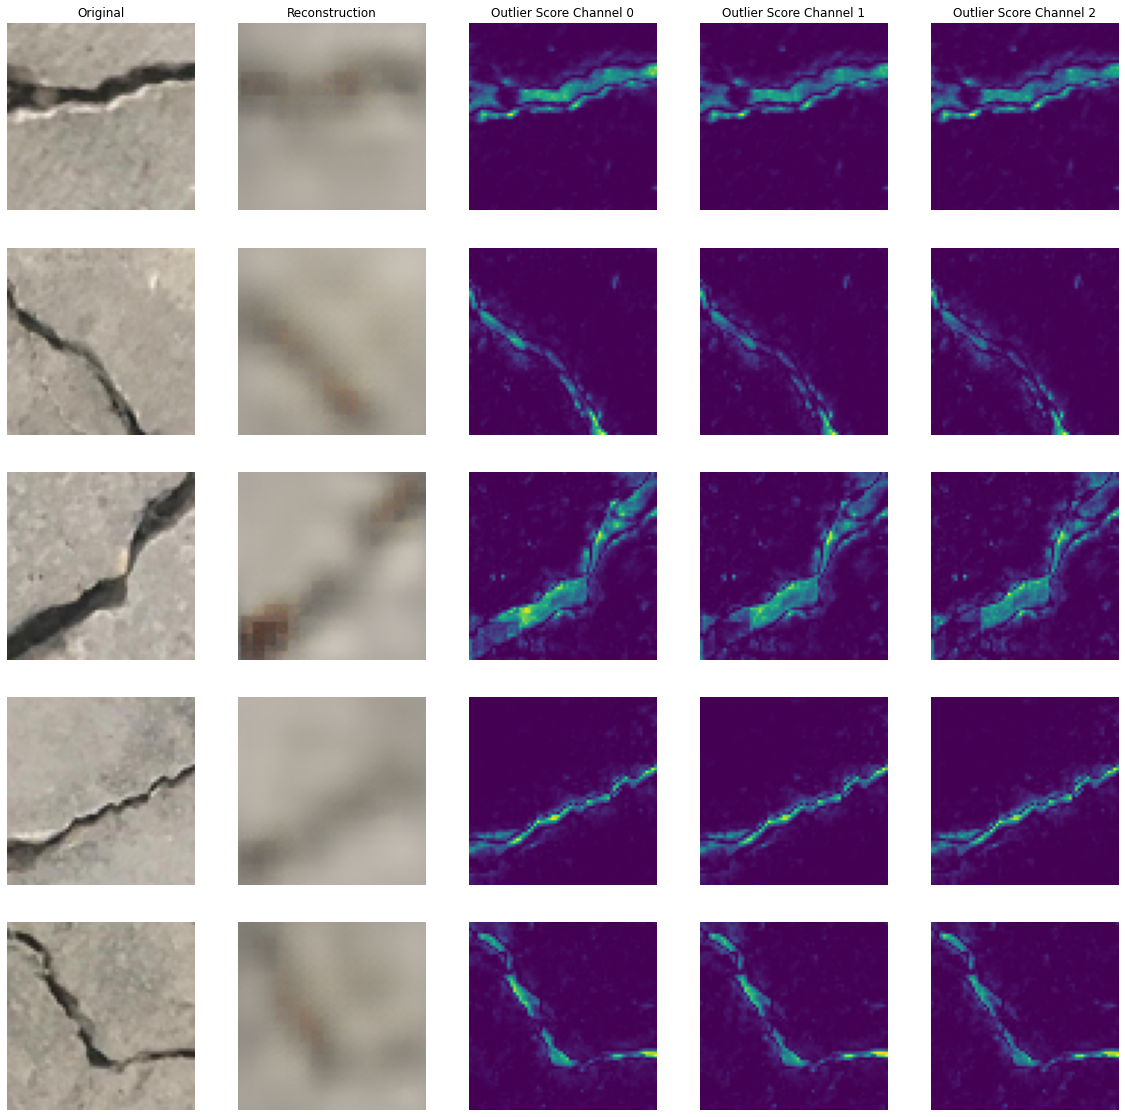

In [18]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

# 결론

Auto Encoder를 사용해서 정상이미지에서 크랙이 생긴 이미지를 빼서 Outlier를 검출 했습니다. 

이런 Crack 데이터를 검출하는 방법은  Classification, Localization, Segmentation, Object Detection과 같이 많은 방법이 있습니다. 

한 예로, 우리가 잘 아는 쏘카에서 Semantic Segmentation인 U-Net을 사용해서 차량의 찌그러짐, 파손들을 검출 하고 있습니다. 

https://tech.socarcorp.kr/data/2020/02/13/car-damage-segmentation-model.html
